# Story 5

Andrew Bowen    
DATA 608    
CUNY Data Science

In [1]:
from matplotlib import pyplot as plt
import requests
import json
import pandas as pd
from io import StringIO, BytesIO
import numpy as np
import os
import gzip

## Data Sources

- [National Oceanic and Atmospheric Administration](https://www.ncei.noaa.gov/access/monitoring/climate-at-a-glance/global/time-series/globe/land_ocean/1/9/1990-2023) - global time series data for 
temperature anomaly since 1990 (posted on [GitHub here]())
- [NOAA API](https://www.ncdc.noaa.gov/cdo-web/webservices/v2#gettingStarted)
- [National Centers for Environmental Information Storm Event Database](https://www.ncdc.noaa.gov/stormevents/ftp.jsp) - data since 1950 no different storm events

In [2]:
()

()

In [3]:
# Read in Temperature anomaly data
temps = pd.read_csv("data/global-temps.csv", header=4)
temps.head()

,Year,Anomaly
0,1990,0.30
1,1991,0.39
2,1992,0.06
3,1993,0.21
4,1994,0.27


## Data Wrangling

In [4]:
# Clean up temperature Data
temps.columns = [c.lower() for c in temps.columns]

temps['year'] = temps.year.astype(str)
temps.head()

,year,anomaly
0,1990,0.30
1,1991,0.39
2,1992,0.06
3,1993,0.21
4,1994,0.27


A *temperature anomaly* in short means a deviation from the average value. In this case, our dataset about shows how much each year *deviated* from the average temperature over the period 1900 - 2000. A postivie value indicates a temperature *above* the average. Enough italics, let's quickly plot our temperature anomalies over time

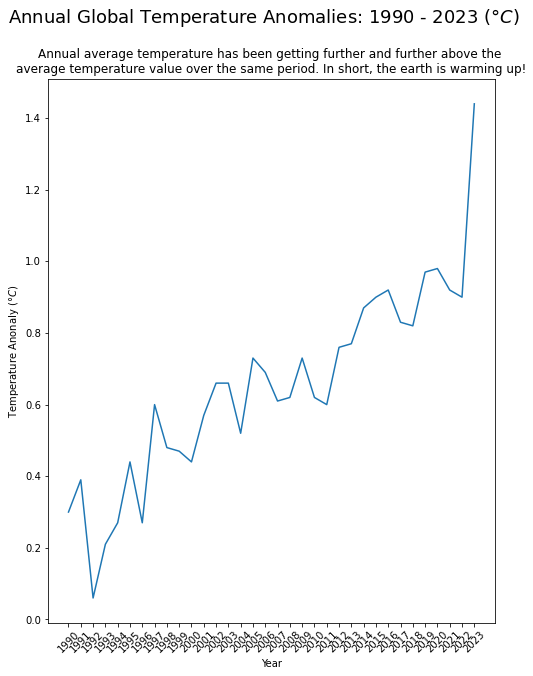

In [5]:
# Plot temperature anomalies
plt.figure(figsize=(8, 10))

plt.plot(temps['year'], temps['anomaly'])

# Add labels and title
plt.xlabel("Year")
plt.ylabel(r"Temperature Anonaly ($\degree C$)")

plt.xticks(rotation=45)
plt.suptitle(r"Annual Global Temperature Anomalies: 1990 - 2023 ($\degree C$)", fontsize=18)
plt.title("Annual average temperature has been getting further and further above the \naverage temperature value over the same period. In short, the earth is warming up!")

plt.show()

In [6]:
token = os.environ["NOAA_TOKEN"]

In [7]:
file_index = pd.read_html("https://www.ncei.noaa.gov/pub/data/swdi/stormevents/csvfiles/")[0]
file_index = file_index.iloc[4:204]


In [8]:
# Clean up file index data a bit
file_index['year'] = file_index['Name'].str.extract("d(\d{4})").astype(int)

# We only care about the past 25 years, so let's filter a bit
file_index = file_index.loc[file_index.year >= 1998]

file_index.head()

,Name,Last modified,Size,Description,year
52,StormEvents_details-ftp_v1.0_d1998_c20220425.c...,2022-04-25 15:06,9.8M,NaN,1998
53,StormEvents_details-ftp_v1.0_d1999_c20220425.c...,2022-04-25 15:06,9.9M,NaN,1999
54,StormEvents_details-ftp_v1.0_d2000_c20220425.c...,2022-04-25 15:06,7.5M,NaN,2000
55,StormEvents_details-ftp_v1.0_d2001_c20220425.c...,2022-04-25 15:06,6.6M,NaN,2001
56,StormEvents_details-ftp_v1.0_d2002_c20220425.c...,2022-04-25 15:06,6.9M,NaN,2002


In [9]:
def get_storm_data(path: str):
    """
    Grab file from NCEI Storm Database
    Grabs compressed CSV file, decodes it and dumps to pandas dataframe
        - https://www.ncei.noaa.gov/pub/data/swdi/stormevents/csvfiles/

    params:
        path (str): Filename or path in the NCEI database
            (e.g., `StormEvents_details-ftp_v1.0_d1950_c20210803.csv.gz`)
    returns:
        dat: (pd.DataFrame) dataframe for a single file
    """

    # Get file content
    url = f"https://www.ncei.noaa.gov/pub/data/swdi/stormevents/csvfiles/{path}"
    r = requests.get(url, stream=True)
    file_like_object = BytesIO(r.content)
    
    # Open and decode file content
    dat = None
    with gzip.open(file_like_object) as g:
        content = g.read()
        dat = pd.read_csv(StringIO(content.decode()))

    return dat



In [10]:
# Get detail files from TOC
detail_indices = file_index.Name.str.contains("details").values
detail_indices

detail_files = file_index.loc[detail_indices]

# Now for fatalities
fatality_indices = file_index.Name.str.contains("fatalities").values
fatality_indices
fatality_files = file_index.iloc[fatality_indices]


In [11]:
# Get detail files first
detail_dfs = []

for index, row in detail_files.iterrows():
    filepath = row['Name']
    dat = get_storm_data(filepath)
    detail_dfs.append(dat)

/var/folders/60/nwdftyjj6cg3ysz_pf9stwtc0000gn/T/ipykernel_913/3806064280.py:6: DtypeWarning: Columns (28) have mixed types.Specify dtype option on import or set low_memory=False.
  dat = get_storm_data(filepath)
/var/folders/60/nwdftyjj6cg3ysz_pf9stwtc0000gn/T/ipykernel_913/3806064280.py:6: DtypeWarning: Columns (29,34,35,37) have mixed types.Specify dtype option on import or set low_memory=False.
  dat = get_storm_data(filepath)


In [63]:
details = pd.concat(detail_dfs)

# Uncomment if you want this file written locally
# details.to_csv("data/storm-details.csv", index=False)

In [13]:
# Get fatality files next
fatality_dfs = []

for index, row in fatality_files.iterrows():
    filepath = row['Name']
    dat = get_storm_data(filepath)
    fatality_dfs.append(dat)



In [14]:
fatalities = pd.concat(fatality_dfs)

# Uncomment if you want this file written locally
# fatalities.to_csv("data/storm-fatalities.csv", index=False)

In [122]:
# Let's
category_mapping = {"1.0": "I", "2.0": "II", "3.0": "III", "4.0": "IV", "5.0": "V"}
details['category_roman'] = details['CATEGORY'].astype(str).map(category_mapping)

categories = details.groupby("category_roman")['category_roman'].count()
categories

category_roman
I      342
II      53
III     26
IV      42
V        8
Name: category_roman, dtype: int64

Text(0.5, 0.98, 'Hurricane Categories: 1998-2022, USA')

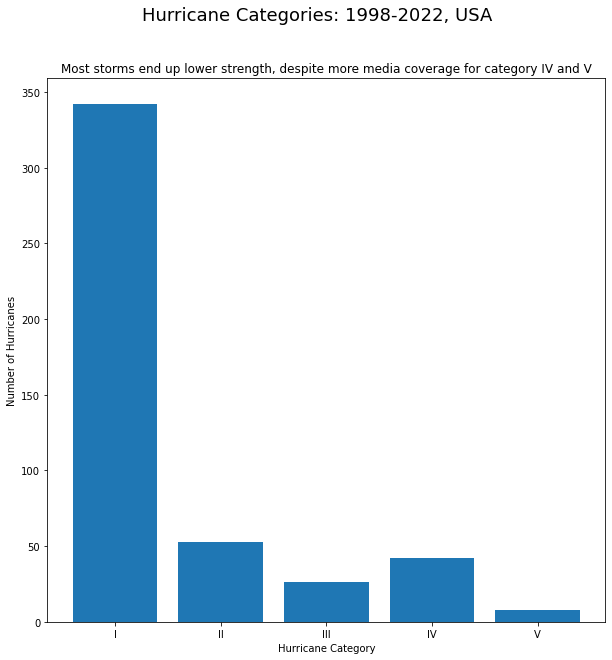

In [123]:


f, ax = plt.subplots(figsize=(10, 10))
plt.bar(categories.index, categories.values)

plt.xlabel("Hurricane Category")
plt.ylabel("Number of Hurricanes")

plt.title("Most storms end up lower strength, despite more media coverage for category IV and V")
plt.suptitle("Hurricane Categories: 1998-2022, USA", fontsize=18)


This graph shows our distribution of categories of hurricanes well (how many hurricaness were in each category *in total*), but we're mostly interested in *change over time*. Primarily, **has the number of hurricanes in category IV and V *increased* over the past 25 years alongside rising temperatures?**

In [124]:
# Let's get detail years 
details['YEAR'] = details['YEAR'].astype(str)



# Let's look at just Category 4 or 5 storms
strong_storms = details.loc[(details['category_roman'] == "III") |
                            (details['category_roman'] == "IV") |
                            (details['category_roman'] == "V")]


strong_storms.head()

,BEGIN_YEARMONTH,BEGIN_DAY,BEGIN_TIME,END_YEARMONTH,END_DAY,END_TIME,EPISODE_ID,EVENT_ID,STATE,STATE_FIPS,...,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,EPISODE_NARRATIVE,EVENT_NARRATIVE,DATA_SOURCE,CETAGORY,cetgory_roman,category_roman
52160,200909,15,100,200909,16,1300,34184,197872,GUAM,98.0,...,NaN,NaN,NaN,NaN,Tropical Depression 15W developed from a distu...,NaN,CSV,4.0,4.0,IV
30020,201212,2,1600,201212,3,1000,70984,426987,GUAM,98.0,...,NaN,NaN,NaN,NaN,"After passing Chuuk on 28 November, Tropical S...",NaN,CSV,5.0,5.0,V
12884,201311,3,1900,201311,7,1900,81102,486009,GUAM,98.0,...,NaN,NaN,NaN,NaN,Haiyan crossed Micronesia from November 3rd to...,On the afternoon of November 1st scatterometer...,CSV,5.0,5.0,V
9756,201503,26,0,201503,31,2359,96339,579262,GUAM,98.0,...,NaN,NaN,NaN,NaN,"Between the 26th and 31st of March, Typhoon Ma...","On the night of the 26th of March, a tropical ...",CSV,5.0,5.0,V
11205,201504,1,0,201504,2,0,99324,596410,GUAM,98.0,...,NaN,NaN,NaN,NaN,Typhoon Maysak had ravaged parts of Micronesia...,Typhoon Maysak formed over eastern Micronesia ...,CSV,5.0,5.0,V


In [128]:
# Now let's plot the number of 
strong_storms_per_year = strong_storms.groupby(["YEAR", "category_roman"])['category_roman'].count()
strong_storms_per_year = pd.DataFrame(strong_storms_per_year)
strong_storms_per_year['storm_count'] = strong_storms_per_year['category_roman']


strong_storms_per_year = strong_storms_per_year.drop("category_roman", axis=1).reset_index()
strong_storms_per_year#.pivot_table(["YEAR", "CATEGORY"], "storm_count")

,YEAR,category_roman,storm_count
0,2009,IV,1
1,2012,V,1
2,2013,V,1
3,2015,IV,1
4,2015,V,2
5,2017,III,4
6,2017,IV,19
7,2018,III,9
8,2018,IV,6
9,2018,V,4


No handles with labels found to put in legend.


Text(0.5, 0.98, 'Hurricane Categories by year, USA')

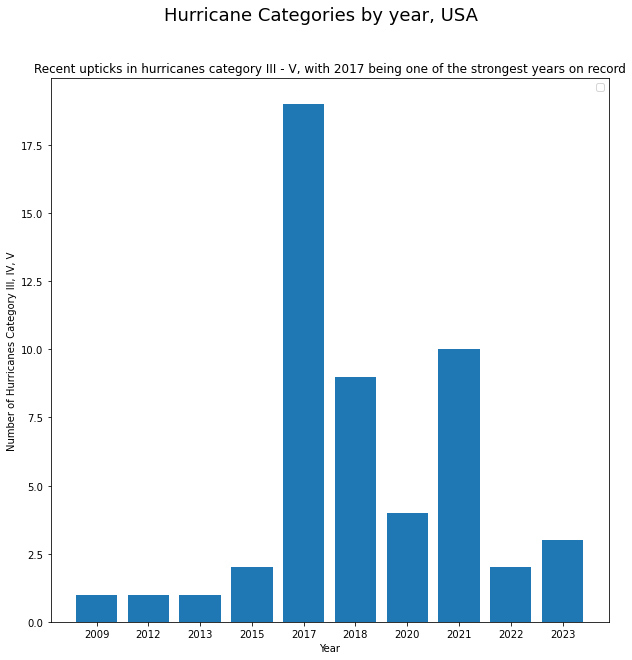

In [131]:
f, ax = plt.subplots(figsize=(10, 10))

plt.bar(strong_storms_per_year.YEAR,
        strong_storms_per_year.storm_count),
        # label=strong_storms_per_year.category_roman)#, label=strong_storms_per_year.CATEGORY)

plt.legend()
plt.xlabel("Year")
plt.ylabel("Number of Hurricanes Category III, IV, V")

plt.title("Recent upticks in hurricanes category III - V, with 2017 being one of the strongest years on record")
plt.suptitle("Strong Hurricanes by year, USA", fontsize=18)